<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/itkimage2segimageNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook does the last step in the split workflow on Terra**

The NIFTI files generated from Totalsegmentator are provided as input and the DICOM files are downloaded again to generate DICOM SEG Objects

Please cite:
Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

In [7]:
import sys
from pathlib import Path
import time
import shutil
import glob
import os
import sys
import time
import pandas as pd
from pathlib import Path

curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Fri Apr  7 15:54:14 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###Installing Packages

In [8]:
# %%capture
# #Installing lz4 for compression/decompression
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 

In [9]:
# %%capture
# dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"
# dcmqi_download_path = f"{curr_dir}/dcmqi-1.2.5-linux.tar.gz"
# dcmqi_path = f"{curr_dir}/dcmqi-1.2.5-linux"

# !wget -O $dcmqi_download_path $dcmqi_release_url

# !tar -xvf $dcmqi_download_path 

# !mv $dcmqi_path/bin/* /bin
# !rm -r $dcmqi_download_path $dcmqi_path

In [10]:
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
# !tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !mv s5cmd /usr/local/bin/s5cmd
# !rm CHANGELOG.md LICENSE README.md

###Parameters

In [11]:
csvFilePath=''
inferenceNiftiFilePath=''

###**For local testing**

In [12]:
# !wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
# csvFilePath = glob.glob('*.csv')[0]

# !wget https://github.com/vkt1414/Cloud-Resources-Workflows/raw/main/sampleManifests/inferenceNiftiFiles.tar.lz4
# #Get the file path of the inferenceNiftiFiles
# inferenceNiftiFilePath=glob.glob('*.lz4')[0]

--2023-04-07 15:54:19--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139861 (137K) [text/plain]
Saving to: ‘batch_1.csv.1’

batch_1.csv.1       100%[===================>] 136.58K  --.-KB/s    in 0.02s   

2023-04-07 15:54:19 (5.86 MB/s) - ‘batch_1.csv.1’ saved [139861/139861]

--2023-04-07 15:54:19--  https://github.com/vkt1414/Cloud-Resources-Workflows/raw/main/sampleManifests/inferenceNiftiFiles.tar.lz4
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/s

###Extracting Inference NIFTI files

In [13]:
try:
  shutil.rmtree(f'Inference')
except OSError:
  pass
!lz4 -d {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf -

Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/
Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/
Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.nii.lz4
Inference/1.2.840.113654.2.55.142419057730651121165090739113900499978/
Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/
Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215.nii.lz4
Inference/1.2.840.113654.2.55.185309182591805634517860395342326800332/
Inference/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033.ni

###Reading CSV File containing s5cmd Urls

In [14]:
start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')  

read in 0.06946206092834473  seconds


###Functions

In [15]:
try:
  shutil.rmtree(f'itkimage2segimage')
except OSError:
  pass
os.mkdir(f'itkimage2segimage')

In [16]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import time
import pandas as pd
import matplotlib.pyplot as plt

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb,  disk_usage_all, disk_total

In [17]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  try:
    shutil.rmtree(f'idc_data/{series_id}')
  except OSError:
    pass
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [18]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole_slicerAsRef.json')
except OSError:
  pass
!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json

--2023-04-07 15:54:21--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76948 (75K) [text/plain]
Saving to: ‘dicomseg_metadata_whole_slicerAsRef.json’

dicomseg_metadata_w 100%[===================>]  75.14K  --.-KB/s    in 0.01s   

2023-04-07 15:54:21 (5.49 MB/s) - ‘dicomseg_metadata_whole_slicerAsRef.json’ saved [76948/76948]



In [19]:
def itkimage2segimage(series_id):
      try:
        shutil.rmtree(f'itkimage2segimage/{series_id}')
      except OSError:
        pass
        os.mkdir(f'itkimage2segimage/{series_id}')

      print("Processing series: "+series_id)  

      """
      Downloading DICOM files only for the Series with Totalsegmentator NIFTI files

      """
      download_dicom_data(series_id) 


      #Get Inference NIFTI file path
      inference_nifti_filename_path = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii.lz4')
      inference_nifti_filename = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii')
      inference_list = []
      inference_list.append(inference_nifti_filename)

      try:
        os.remove(inference_nifti_filename)
      except OSError:
        pass
      !lz4 -d {inference_nifti_filename_path}
      #remove the compressed file after decompressing
      !rm -r {inference_nifti_filename_path}
       
      start_time = time.time()
      !itkimage2segimage --inputImageList {inference_nifti_filename} --inputDICOMDirectory {curr_dir}/idc_data/ --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/dicomseg_metadata_whole_slicerAsRef.json --skip >> /dev/null
      itkimage2segimage_time = time.time() - start_time
      print("Done in %g seconds."%itkimage2segimage_time)
      
      check_itkimage_errors(series_id)

      start_time = time.time()     
      !lz4 {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm  {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm.lz4
      archiving_time = time.time() - start_time
      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      log['itkimage2segimage_time']=itkimage2segimage_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}
      !rm -r {curr_dir}/idc_data
      !rm -r {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [20]:
def remove_directories_without_nii_files(path):
    for dirpath, dirnames, filenames in os.walk(path, topdown=False):
        if dirpath != path and not any(filename.endswith('.nii.lz4') for filename in filenames):
            try:
                os.rmdir(dirpath)
            except OSError as e:
                print(f"Error: Failed to remove directory {dirpath}: {e}")

In [21]:
#removing empty directories
remove_directories_without_nii_files(os.path.join(curr_dir,'Inference/'))

In [22]:
def check_itkimage_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('itkimage2segimage_error_file.txt', 'a') as f:
            f.write(f"Error: itkimage2segimage failed for series {series_id}\n")
        return True
    return False

###Convert Inference NIFTI file to DICOM_SEG Object

Processing series: 1.2.840.113654.2.55.100875189782210690344207306235124901243
Copying files from IDC buckets..
Done in 1.03407 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243.nii 
/content/Inference/1 : decoded 35401152 bytes 
Done in 8.9056 seconds.
Compressed 93066298 bytes into 768877 bytes ==> 0.83%


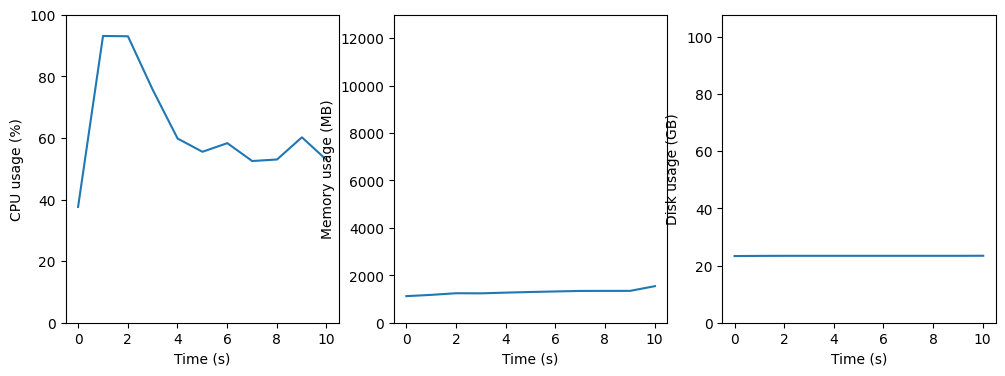

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033
Copying files from IDC buckets..
Done in 0.720421 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033.nii 
/content/Inference/1 : decoded 30158272 bytes 
Done in 7.65762 seconds.
Compressed 82932556 bytes into 645412 bytes ==> 0.78%


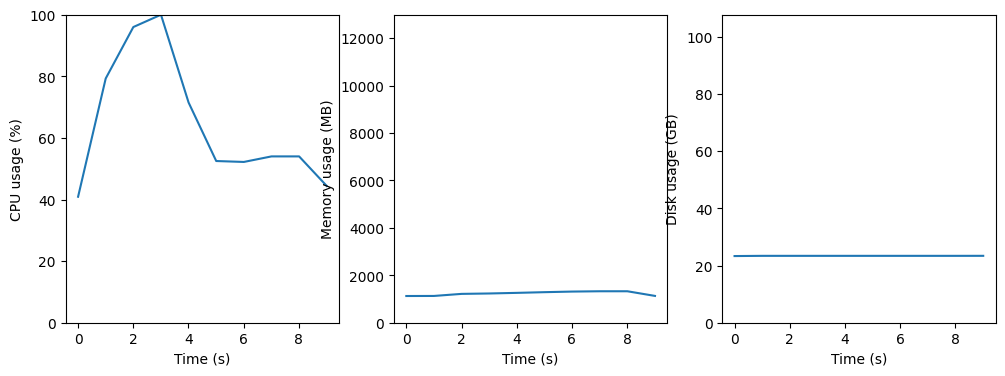

Processing series: 1.2.840.113654.2.55.243990451406006403331425809632881193215
Copying files from IDC buckets..
Done in 0.726686 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215.nii 
/content/Inference/1 : decoded 47197632 bytes 
Done in 13.6018 seconds.
Compressed 123668124 bytes into 953035 bytes ==> 0.77%


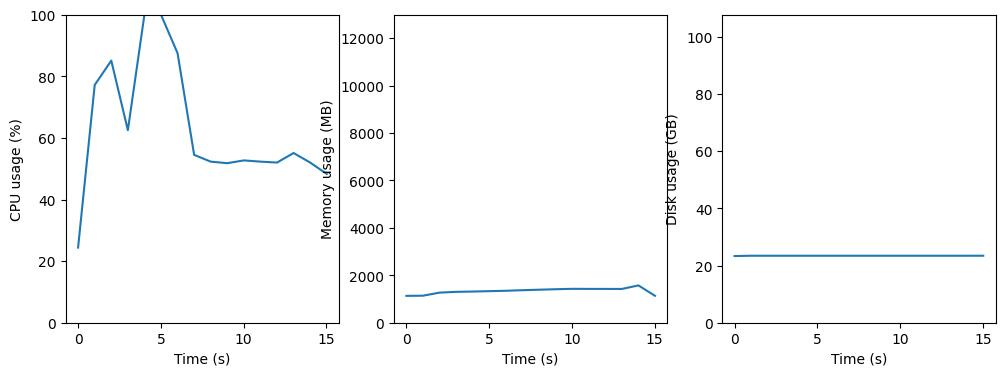

Processing series: 1.2.840.113654.2.55.154809705591242159075253605419469935510
Copying files from IDC buckets..
Done in 0.728013 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510.nii 
/content/Inference/1 : decoded 29371840 bytes 
Done in 5.75547 seconds.
Compressed 71332302 bytes into 564981 bytes ==> 0.79%


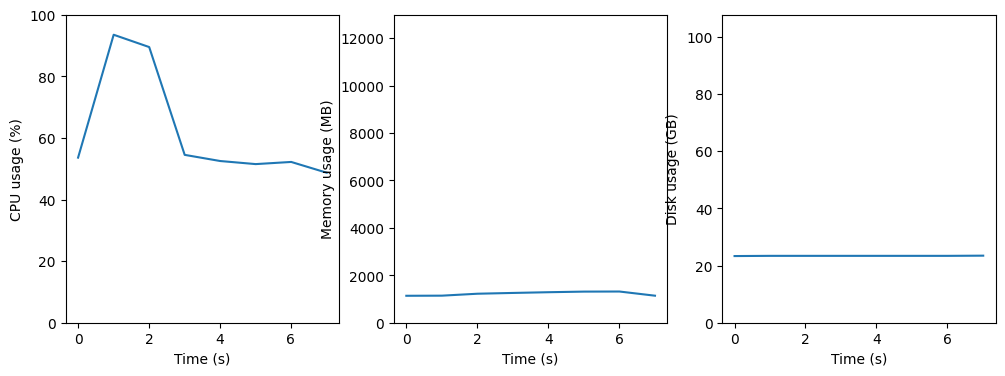

Processing series: 1.2.840.113654.2.55.185309182591805634517860395342326800332
Copying files from IDC buckets..
Done in 0.622026 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332.nii 
/content/Inference/1 : decoded 41430464 bytes 
Done in 13.2773 seconds.
Compressed 117553156 bytes into 886939 bytes ==> 0.75%


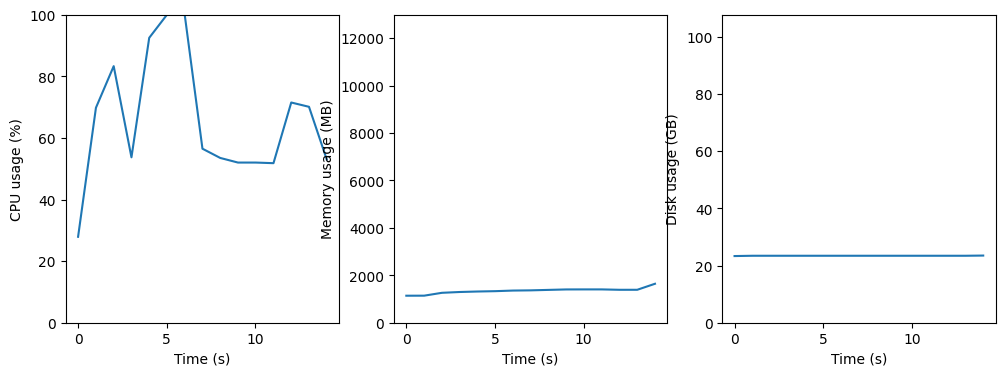

Processing series: 1.2.840.113654.2.55.216614002338888733987350522981366678482
Copying files from IDC buckets..
Done in 0.619787 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482.nii 
/content/Inference/1 : decoded 34090432 bytes 
Done in 8.65813 seconds.
Compressed 87966350 bytes into 731094 bytes ==> 0.83%


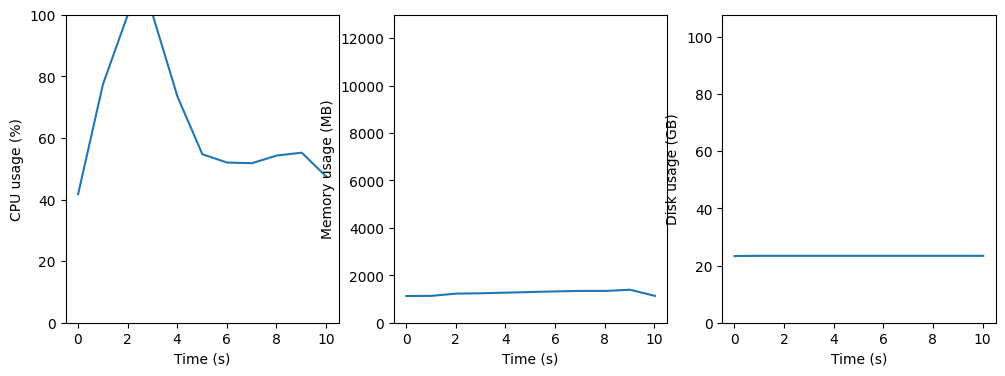

Processing series: 1.2.840.113654.2.55.22770087029972268579113866309746562015
Copying files from IDC buckets..
Done in 0.620952 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.nii 
/content/Inference/1 : decoded 33566144 bytes 
Done in 8.45111 seconds.
Compressed 82700106 bytes into 702300 bytes ==> 0.85%


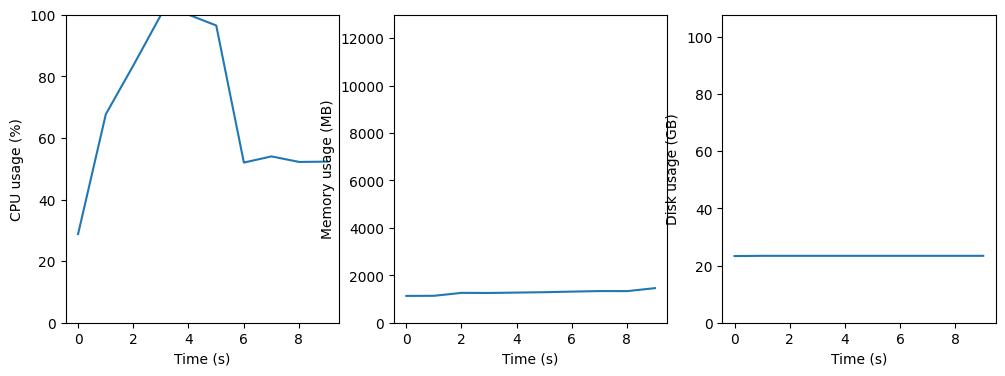

Processing series: 1.2.840.113654.2.55.146601594654322994982630019583270053397
Copying files from IDC buckets..
Done in 0.518777 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397.nii 
/content/Inference/1 : decoded 36449728 bytes 
Done in 9.87652 seconds.
Compressed 96367156 bytes into 767780 bytes ==> 0.80%


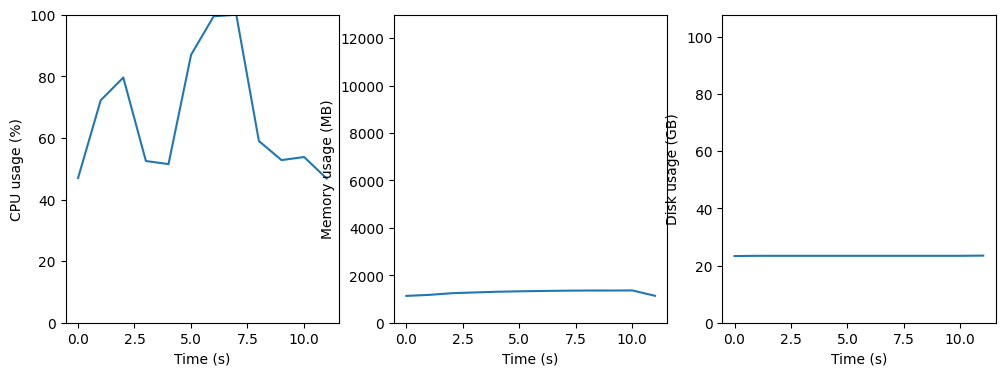

Processing series: 1.2.840.113654.2.55.113040386178547843571271236478024341696
Copying files from IDC buckets..
Done in 0.720268 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696.nii 
/content/Inference/1 : decoded 50081216 bytes 
Done in 17.0953 seconds.
Compressed 136901358 bytes into 1027306 bytes ==> 0.75%


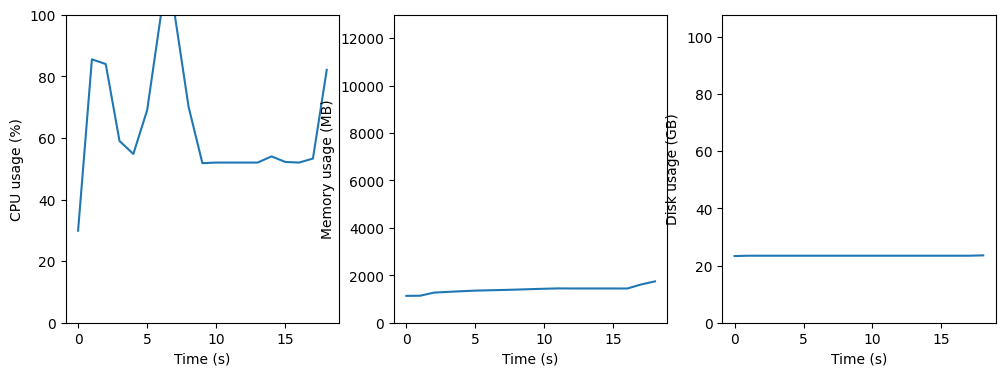

Processing series: 1.2.840.113654.2.55.14382674871619950799472325766084940706
Copying files from IDC buckets..
Done in 0.520675 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706.nii 
/content/Inference/1 : decoded 31993280 bytes 
Done in 6.74689 seconds.
Compressed 80965748 bytes into 678515 bytes ==> 0.84%


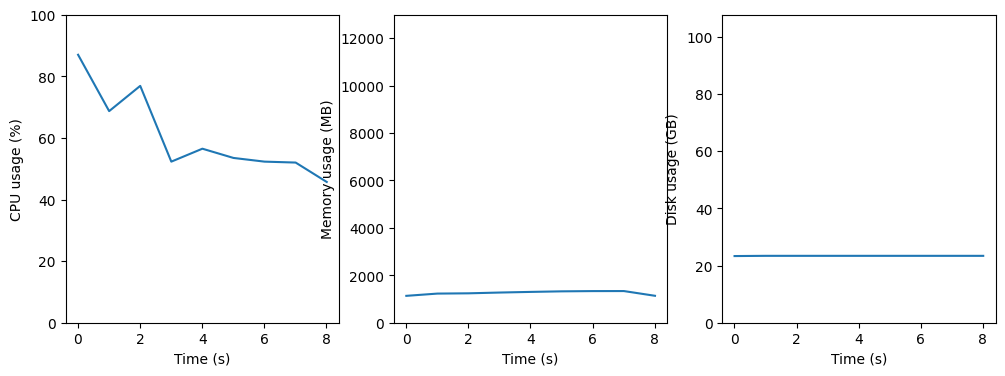

In [23]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','itkimage2segimage_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'Inference'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(itkimage2segimage, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [24]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4')
except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > {curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4
output_archiving_time = time.time() - start_time

tar: Removing leading `/' from member names
/content/itkimage2segimage/
/content/itkimage2segimage/1.2.840.113654.2.55.100875189782210690344207306235124901243/
/content/itkimage2segimage/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243.dcm.lz4
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033.dcm.lz4
/content/itkimage2segimage/1.2.840.113654.2.55.243990451406006403331425809632881193215/
/content/itkimage2segimage/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215.dcm.lz4
/content/itkimage2segimage/1.2.840.113654.2.55.154809705591242159075253605419469935510/
/content/itkimage2segimage/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.1

###Utilization Metrics

In [25]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_archiving_time']=output_archiving_time
try:
  os.remove('itkimage2segimageUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv itkimage2segimageUsageMetrics.lz4
runtime_stats

Compressed 6455 bytes into 3113 bytes ==> 48.23%


,SeriesInstanceUID,itkimage2segimage_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total,output_archiving_time
0,1.2.840.113654.2.55.10087518978221069034420730...,8.905596,0.125296,"[[[37.6, 93.1, 93.0, 75.6, 59.8, 55.5, 58.3, 5...","[[[1120.43359375, 1174.34765625, 1243.37109375...",[12985.546875],"[[[23.314651489257812, 23.37218475341797, 23.4...",107.715084,0.128602
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401...,7.657620,0.119194,"[[[40.9, 79.3, 96.0, 100.0, 71.5, 52.5, 52.2, ...","[[[1126.34765625, 1128.78125, 1215.984375, 123...",[12985.546875],"[[[23.31460952758789, 23.389087677001953, 23.3...",107.715084,0.128602
2,1.2.840.113654.2.55.24399045140600640333142580...,13.601804,0.123427,"[[[24.4, 77.2, 85.1, 62.5, 100.0, 100.0, 87.5,...","[[[1132.75, 1139.87109375, 1268.125, 1301.6679...",[12985.546875],"[[[23.314533233642578, 23.42876434326172, 23.4...",107.715084,0.128602
3,1.2.840.113654.2.55.15480970559124215907525360...,5.755471,0.119990,"[[[53.6, 93.5, 89.5, 54.5, 52.5, 51.5, 52.2, 4...","[[[1136.08203125, 1140.8984375, 1222.60546875,...",[12985.546875],"[[[23.31439971923828, 23.387516021728516, 23.3...",107.715084,0.128602
4,1.2.840.113654.2.55.18530918259180563451786039...,13.277273,0.114618,"[[[27.9, 69.8, 83.3, 53.7, 92.5, 100.0, 100.0,...","[[[1138.86328125, 1140.55859375, 1261.09765625...",[12985.546875],"[[[23.314186096191406, 23.418006896972656, 23....",107.715084,0.128602
5,1.2.840.113654.2.55.21661400233888873398735052...,8.658128,0.121115,"[[[41.7, 77.4, 100.0, 100.0, 73.4, 54.7, 52.0,...","[[[1125.8515625, 1131.7265625, 1226.94140625, ...",[12985.546875],"[[[23.314071655273438, 23.399513244628906, 23....",107.715084,0.128602
6,1.2.840.113654.2.55.22770087029972268579113866...,8.451105,0.119202,"[[[28.8, 67.7, 83.6, 100.0, 100.0, 96.5, 52.0,...","[[[1130.39453125, 1135.59765625, 1259.38671875...",[12985.546875],"[[[23.313926696777344, 23.39700698852539, 23.3...",107.715084,0.128602
7,1.2.840.113654.2.55.14660159465432299498263001...,9.876520,0.118204,"[[[47.0, 72.2, 79.6, 52.5, 51.5, 87.0, 99.5, 1...","[[[1131.09375, 1173.30859375, 1243.171875, 127...",[12985.546875],"[[[23.313819885253906, 23.40099334716797, 23.4...",107.715084,0.128602
8,1.2.840.113654.2.55.11304038617854784357127123...,17.095264,0.124310,"[[[29.9, 85.5, 84.0, 59.0, 54.8, 69.0, 100.0, ...","[[[1132.5078125, 1137.8671875, 1269.83203125, ...",[12985.546875],"[[[23.313823699951172, 23.435462951660156, 23....",107.715084,0.128602
9,1.2.840.113654.2.55.14382674871619950799472325...,6.746891,0.122364,"[[[87.0, 68.7, 76.9, 52.3, 56.5, 53.5, 52.3, 5...","[[[1133.31640625, 1228.265625, 1239.70703125, ...",[12985.546875],"[[[23.31383514404297, 23.39322280883789, 23.39...",107.715084,0.128602
